## Part 1

### Build a logistic regression model to predict two-year recidivism.

#### First, import libraries
- pandas for loading csv data into dataframe object, used to then convert into torch tensor which is the form our input assumes
- numpy for linear algebra operations
- sklearn.model_selection for its train_test_split function
- torch for model implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

#### Construct train and test data sets
- load from csv
- use train_test_split function to create separate dataframe objects for the 2 sets
- extract relevant columns to obtain X and y for train and test

In [2]:
'''
According to Dressel, Julia, and Hany Farid. “The accuracy, fairness, and limits of predicting recidivism.”:
Despite the impressive collection of 137 features, it would appear that a linear classifier based on only 2
features—age and total number of previous convictions—is all that is
required to yield the same prediction accuracy as COMPAS.
'''

# Extract data from .csv file related to Black and White defendants
recidivism_df = pd.read_csv('compas-scores-two-years.csv') 
recidivism_df = recidivism_df[(recidivism_df["race"] == "Caucasian") | (recidivism_df["race"] == "African-American")]

# From dataframe, create input and output data for train and test sets.
train_df, test_df = train_test_split(recidivism_df, test_size=0.4)
X_train = torch.tensor(train_df[['age', 'priors_count']].to_numpy()).type(torch.FloatTensor)
y_train = torch.tensor(train_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)
X_test = torch.tensor(test_df[['age', 'priors_count']].to_numpy()).type(torch.FloatTensor)
y_test = torch.tensor(test_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

#### Create train_data and test_data.
- each is an array of tuples (x, y) 
- each tuple (x, y) is a sample datapoint where x = input = [age, prior count] and y = output = two_year_recid result

In [3]:
# Initialize
train_data, test_data = [], []

# Create train data
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])
    
# Create test data
for i in range(len(X_test)):
    test_data.append([X_test[i], y_test[i]])

#### Print Sample Datapoint

In [4]:
train_data[0] # should gives us [tensor([?,?]), tensor(?)]

[tensor([28.,  9.]), tensor(1.)]

#### Declare batch_size = 256 and construct dataloader objects for training and testing. Dataloader objects will allow us to go through dataset in batches during training and testing phases

In [5]:
# Declare + Initialize batch size
batch_size = 256

# Create train and test dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

#### Declare LogisticRegression Model. This consists of a linear function of input features, followed by a sigmoid activation function to produce an output. Sigmoid will return a value between 0 and 1, which is good because we want a measure of probability of recidivism. We interpret 1 as high risk of recidivism and 0 as low risk of recidivism

In [6]:
device = "cpu" # Too poor for GPU

# Logistic Regression Model
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim) # linear layer
        
    def forward(self, inp):
        logits_post_sigmoid = torch.sigmoid(self.linear(inp)) # sigmoid function
        return logits_post_sigmoid

# Create model
model = LogisticRegression(2,1).to(device)
print(model)

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


#### Train Logistic Regression Model

In [7]:
# Binary Cross-Entropy loss function and Adam Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    # loop through batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) 
        
        # Compute loss
        pred = model(X)
        loss = loss_fn(torch.squeeze(pred).type(torch.FloatTensor), y.type(torch.FloatTensor))
        
        # Compute gradient with respect to model parameters and update parameters through step() function
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Output batch loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test function
def test(dataloader, model, loss_fn, dataset):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    # We want to return loss on test set, as well as accuracy on test set
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(torch.squeeze(pred).type(torch.FloatTensor), y.type(torch.FloatTensor)).item() # update loss
            correct += np.sum(torch.squeeze(pred).round().numpy() == y.numpy()) # Update accuracy
    
    # Compute average loss and percentage accuracy
    test_loss /= num_batches # average loss since loss_fn computes average for each batch, we only need to divide by batch size since it is a constant
    correct /= size
    
    # Print results
    print(f"{dataset} Dataset Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss

# Train for 300 epochs, and keep track of train and test losses. No need for validation set.
epochs = 300
train_losses_per_epoch = []
test_losses_per_epoch = []

# Execute training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_loss = test(train_dataloader, model, loss_fn, "Train")
    train_losses_per_epoch.append(train_loss)
    test_loss = test(test_dataloader, model, loss_fn, "Test")
    test_losses_per_epoch.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 7.983647  [    0/ 3690]
loss: 4.998339  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 54.3%, Avg loss: 4.598137 

Test Dataset Error: 
 Accuracy: 52.0%, Avg loss: 4.800653 

Epoch 2
-------------------------------
loss: 5.078629  [    0/ 3690]
loss: 2.583717  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 54.3%, Avg loss: 1.983161 

Test Dataset Error: 
 Accuracy: 52.0%, Avg loss: 2.067289 

Epoch 3
-------------------------------
loss: 2.190979  [    0/ 3690]
loss: 0.668992  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 47.3%, Avg loss: 0.721968 

Test Dataset Error: 
 Accuracy: 49.7%, Avg loss: 0.705934 

Epoch 4
-------------------------------
loss: 0.696549  [    0/ 3690]
loss: 0.758593  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 62.4%, Avg loss: 0.638168 

Test Dataset Error: 
 Accuracy: 63.5%, Avg loss: 0.631734 

Epoch 5
-------------------------------
loss: 0.640350  [    0/ 3690]
loss: 0.617655  [ 2560/ 3690]
Train Dataset Er

loss: 0.641025  [    0/ 3690]
loss: 0.607697  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.8%, Avg loss: 0.620584 

Test Dataset Error: 
 Accuracy: 66.6%, Avg loss: 0.621370 

Epoch 39
-------------------------------
loss: 0.641172  [    0/ 3690]
loss: 0.607769  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.7%, Avg loss: 0.620633 

Test Dataset Error: 
 Accuracy: 66.4%, Avg loss: 0.621465 

Epoch 40
-------------------------------
loss: 0.641321  [    0/ 3690]
loss: 0.607840  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.7%, Avg loss: 0.620685 

Test Dataset Error: 
 Accuracy: 66.4%, Avg loss: 0.621561 

Epoch 41
-------------------------------
loss: 0.641472  [    0/ 3690]
loss: 0.607910  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.6%, Avg loss: 0.620738 

Test Dataset Error: 
 Accuracy: 66.5%, Avg loss: 0.621658 

Epoch 42
-------------------------------
loss: 0.641624  [    0/ 3690]
loss: 0.607980  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.6%, Avg loss: 0.

loss: 0.647772  [    0/ 3690]
loss: 0.609689  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.2%, Avg loss: 0.623478 

Test Dataset Error: 
 Accuracy: 66.0%, Avg loss: 0.625983 

Epoch 78
-------------------------------
loss: 0.647951  [    0/ 3690]
loss: 0.609712  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.2%, Avg loss: 0.623566 

Test Dataset Error: 
 Accuracy: 66.0%, Avg loss: 0.626111 

Epoch 79
-------------------------------
loss: 0.648128  [    0/ 3690]
loss: 0.609732  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.2%, Avg loss: 0.623655 

Test Dataset Error: 
 Accuracy: 66.0%, Avg loss: 0.626237 

Epoch 80
-------------------------------
loss: 0.648304  [    0/ 3690]
loss: 0.609751  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.2%, Avg loss: 0.623743 

Test Dataset Error: 
 Accuracy: 66.0%, Avg loss: 0.626363 

Epoch 81
-------------------------------
loss: 0.648479  [    0/ 3690]
loss: 0.609769  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 67.2%, Avg loss: 0.


Epoch 116
-------------------------------
loss: 0.653186  [    0/ 3690]
loss: 0.609772  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 66.3%, Avg loss: 0.626313 

Test Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.629887 

Epoch 117
-------------------------------
loss: 0.653275  [    0/ 3690]
loss: 0.609763  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 66.3%, Avg loss: 0.626362 

Test Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.629951 

Epoch 118
-------------------------------
loss: 0.653362  [    0/ 3690]
loss: 0.609754  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.9%, Avg loss: 0.626409 

Test Dataset Error: 
 Accuracy: 65.2%, Avg loss: 0.630014 

Epoch 119
-------------------------------
loss: 0.653446  [    0/ 3690]
loss: 0.609745  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.9%, Avg loss: 0.626456 

Test Dataset Error: 
 Accuracy: 65.2%, Avg loss: 0.630076 

Epoch 120
-------------------------------
loss: 0.653528  [    0/ 3690]
loss: 0.609736  [ 2560/ 3690]
Train

Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627453 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631383 

Epoch 154
-------------------------------
loss: 0.655263  [    0/ 3690]
loss: 0.609467  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627470 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631405 

Epoch 155
-------------------------------
loss: 0.655292  [    0/ 3690]
loss: 0.609462  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627486 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631426 

Epoch 156
-------------------------------
loss: 0.655319  [    0/ 3690]
loss: 0.609456  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627502 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631446 

Epoch 157
-------------------------------
loss: 0.655346  [    0/ 3690]
loss: 0.609451  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627517 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631864 

Epoch 192
-------------------------------
loss: 0.655896  [    0/ 3690]
loss: 0.609324  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627831 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631870 

Epoch 193
-------------------------------
loss: 0.655904  [    0/ 3690]
loss: 0.609322  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627835 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631876 

Epoch 194
-------------------------------
loss: 0.655913  [    0/ 3690]
loss: 0.609320  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627840 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631882 

Epoch 195
-------------------------------
loss: 0.655920  [    0/ 3690]
loss: 0.609318  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627845 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.631888 

Epoch 196
-------------------------------
loss: 

Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627939 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632008 

Epoch 231
-------------------------------
loss: 0.656086  [    0/ 3690]
loss: 0.609272  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627940 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632010 

Epoch 232
-------------------------------
loss: 0.656088  [    0/ 3690]
loss: 0.609272  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627942 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632012 

Epoch 233
-------------------------------
loss: 0.656091  [    0/ 3690]
loss: 0.609271  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627943 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632014 

Epoch 234
-------------------------------
loss: 0.656093  [    0/ 3690]
loss: 0.609270  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627944 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss

loss: 0.609255  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627972 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632050 

Epoch 269
-------------------------------
loss: 0.656141  [    0/ 3690]
loss: 0.609255  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627972 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632051 

Epoch 270
-------------------------------
loss: 0.656142  [    0/ 3690]
loss: 0.609255  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627973 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632051 

Epoch 271
-------------------------------
loss: 0.656142  [    0/ 3690]
loss: 0.609254  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627973 

Test Dataset Error: 
 Accuracy: 65.3%, Avg loss: 0.632052 

Epoch 272
-------------------------------
loss: 0.656143  [    0/ 3690]
loss: 0.609254  [ 2560/ 3690]
Train Dataset Error: 
 Accuracy: 65.7%, Avg loss: 0.627974 

Test Dataset Erro

The average test loss per batch is around 0.62 for both train and test datasets. There is no sign of overfit, and stagnancy of the model accuracy at 62% suggests that there is no point of training for further epochs. This is likely due to a simple model. Note that there is no validation set here. There does not need to be, because we fix the hyperparameters. Validation set would be used if we were to adjust hyperparameters based on a separate validation set

#### Plot train and test losses against number of epochs

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Test Loss per Epoch')]

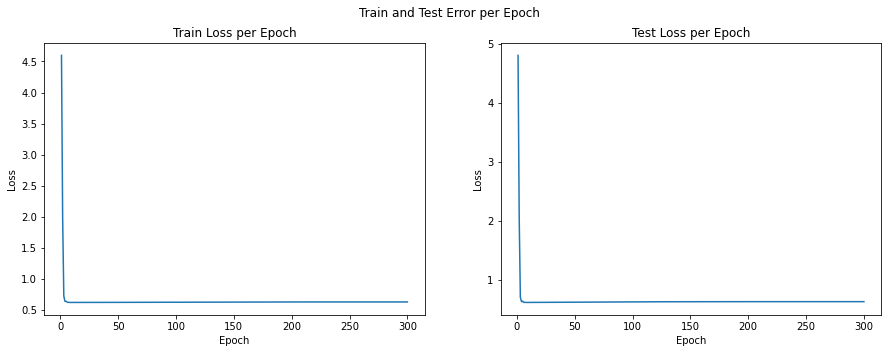

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle("Train and Test Error per Epoch")
ax1.plot(list(range(1,epochs+1)), train_losses_per_epoch)
ax1.set(xlabel='Epoch', ylabel='Loss', title="Train Loss per Epoch")
ax2.plot(list(range(1,epochs+1)), test_losses_per_epoch)
ax2.set(xlabel='Epoch', ylabel='Loss', title="Test Loss per Epoch")

### Show that your model satisfies calibration, but fails to satisfy false-positive parity. Relate this to the difference in base rates in the dataset.

Intuitively, we will only use the test dataset. The training dataset was used to improve the model, so we do not use it to evaluate the model. Instead, we compute the different fairness criteria by applying our model to the test dataset extracted at the beginning. This is a rule of thumb when assessing generalization of ML models.

In [32]:
# Set threshold to 0.5 for this run. We will adjust it later.
threshold = 0.5

black_highrisk = 0 # person is black + model predicts high risk of recidivism
black_highrisk_recidivate = 0 # person is black + model predicts high risk of recidivism + person actually recidivates

white_highrisk = 0 # person is white + model predicts high risk of recidivism
white_highrisk_recidivate = 0 # person is white + model predicts high risk of recidivism + person actually recidivates

black_lowrisk = 0 # person is black + model predicts low risk of recidivism
black_lowrisk_recidivate = 0 # person is black + model predicts low risk of recidivism + person actually recidivates

white_lowrisk = 0 # person is white + model predicts low risk of recidivism
white_lowrisk_recidivate = 0 # person is white + model predicts low risk of recidivism + person actually recidivates

black_notrecidivate = 0 # person is black + does not actually recidivate
black_highrisk_notrecidivate = 0 # person is black + model predicts high risk of recidivism + person does not actually recidivate

white_notrecidivate = 0 # person is white + person does not actually recidivate
white_highrisk_notrecidivate = 0 # person is white + model predicts high risk of recidivism + person does not actually recidivate

# Base rates
white = 0 # white count
white_recidivate = 0 # white + recidivate count
black = 0 # black
black_recidivate = 0 # black + recidivate count

# Loop through test set, increment each variable above when appropriate
for _, row in  test_df.iterrows():
    x = torch.tensor([row['age'], row['priors_count']]).type(torch.FloatTensor)
    
    # Extract race + true recidivism 
    if row['race'] == "African-American":
        black+=1
        if row['two_year_recid'] == 1:
            black_recidivate += 1
    else:
        white+=1
        if row['two_year_recid'] == 1:
            white_recidivate += 1
    
    # Use trained model to make prediction
    pred = 1 if model(x).item() >= threshold else 0
    
    # Update variable related to prediction, race and true recidivism 
    # Black + High Risk
    if row['race'] == 'African-American' and pred == 1:
        black_highrisk += 1
        if row['two_year_recid'] == 1:
            black_highrisk_recidivate += 1
        else:
            black_notrecidivate += 1
            black_highrisk_notrecidivate += 1
    
    # White + High Risk
    elif row['race'] == 'Caucasian' and pred == 1:
        white_highrisk += 1
        if row['two_year_recid'] == 1:
            white_highrisk_recidivate += 1
        else:
            white_notrecidivate += 1
            white_highrisk_notrecidivate += 1
    
    # Black + Low Risk
    elif row['race'] == 'African-American' and pred == 0:
        black_lowrisk += 1
        if row['two_year_recid'] == 1:
            black_lowrisk_recidivate += 1
        else:
            black_notrecidivate += 1
    
    # White + Low Risk
    elif row['race'] == 'Caucasian' and pred == 0:
        white_lowrisk += 1
        if row['two_year_recid'] == 1:
            white_lowrisk_recidivate += 1
        else:
            white_notrecidivate += 1

# Print results. Use Bayes' rule for computations
# Calibration metrics
print("Calibration")
print(f"P(recidivate | black, highrisk) = {black_highrisk_recidivate/black_highrisk}")
print(f"P(recidivate | white, highrisk) = {white_highrisk_recidivate/white_highrisk}")
print("--------------------")
print(f"P(recidivate | black, lowrisk) = {black_lowrisk_recidivate/black_lowrisk}")
print(f"P(recidivate | white, lowrisk) = {white_lowrisk_recidivate/white_lowrisk}")

# False positive parity metric
print("\nFalse Postive Parity")
print(f"P(highrisk | black, did not recidivate) = {black_highrisk_notrecidivate/black_notrecidivate}")
print(f"P(highrisk | white, did not recidivate) = {white_highrisk_notrecidivate/white_notrecidivate}")

# Difference in base rate = difference between proportion that recidivate in the two groups
print("\nBase Rates")
print(f"P(recidivate | black) = {black_recidivate/black}")
print(f"P(recidivate | white) = {white_recidivate/white}")

Calibration
P(recidivate | black, highrisk) = 0.7529644268774703
P(recidivate | white, highrisk) = 0.75
--------------------
P(recidivate | black, lowrisk) = 0.39609053497942387
P(recidivate | white, lowrisk) = 0.36634844868735084

False Postive Parity
P(highrisk | black, did not recidivate) = 0.175561797752809
P(highrisk | white, did not recidivate) = 0.06349206349206349

Base Rates
P(recidivate | black) = 0.5182679296346414
P(recidivate | white) = 0.4226069246435845


As expected, the numbers listed above suggest that calibration is satisfied, but false-positive parity is not. As we can see, the probability of recidivism given high risk are similar for both demographics (races); specifically, they are both close to 0.75, with deviation of 0.3%. Liekwise, the probability of recidivism given low risk are also similar for the demographics; both are around 0.38, with a deviation of 3% between the two measures. The reason for a greater deviation than positive parity values (3% vs 0.03%)  could be explained by an imperfect model and unexhaustive dataset. However, the deviation is still small enough to be considered insignificant. Combining these two results, we confirm calibration- our model's prediction can be considered to mean the same level of risk regardless of demographic.

On the downside, our model clearly fails to satisfy false positive parity. The probability of being classified as high risk given a person does not end up recidivating after 2 years is significantly higher for black population than white population. According to the paper of Corbett-Davies and Goel, "various classification parity constraints (specifically, equal positive/negative predictive values, and equal false positive/negative rates) are incompatible if base rates differ across groups. Kleinberg et al. (2017b) prove that except in degenerate cases, no algorithm can simultaneously satisfy calibration and a particular form of classification parity." This helps explain the discrepancy above. We have satisfied calibration (to a large extent), so we can only expect to fail with false parity. This is indeed the case, black people have false positive rates approximately 3 times larger than white people. 

Different base rates can explain the incompatibility of the two measures. Assume for sake of contradiction it is possible to achieve both calibration and false positive parity. If we reach false positive parity, that means the demographic with a higher portion of truly innocent (not recidivate) people has a higher portion who are innocent and predicted to recidivate, as well as innocent and predicted not to recidivate. Now, due to calibration, this demographic must in turn have a higher portion of people who are guilty(recidivate) and predicted to recidivate, as well as guilty and predicted not to recidivate. However, this would mean that the sum of all 4 probabilities for this demographic is > sum of all 4 demographics for other demographic, which is a contradiction since both must sum to 1.

### Following the paper of Corbett-Davies and Goel, show that adjusting the thresholds can lead to an algorithm that does not satisfy calibration, but does satisfy false-positive parity.

In [41]:
# It is likely that many other tuples work, but we chose tuple that gave closest fpr for the two demographics after some time spent playing around randomly
# Note: we want black threshold to be high, to make prediction = 1 more stricter so we can obtain less false recidivism predictions
white_threshold = 0.5
black_threshold = 0.62

'''
This is all the same as before
'''
black_highrisk = 0
black_highrisk_recidivate = 0

white_highrisk = 0
white_highrisk_recidivate = 0

black_lowrisk = 0
black_lowrisk_recidivate = 0

white_lowrisk = 0
white_lowrisk_recidivate = 0

black_notrecidivate = 0
black_highrisk_notrecidivate = 0

white_notrecidivate = 0
white_highrisk_notrecidivate = 0

white = 0
white_recidivate = 0
black = 0
black_recidivate = 0

for _, row in  test_df.iterrows():
    x = torch.tensor([row['age'], row['priors_count']]).type(torch.FloatTensor)
    
    if row['race'] == "African-American":
        black+=1
        if row['two_year_recid'] == 1:
            black_recidivate += 1
    else:
        white+=1
        if row['two_year_recid'] == 1:
            white_recidivate += 1
            
    # Only difference- prediction is race-dependent, threshold is a function of race
    # Of course, we should expect calibration to break then
    if row["race"] == "African-American":
        pred = 1 if model(x).item() >= black_threshold else 0
    else:
        pred = 1 if model(x).item() >= white_threshold else 0      
        
    if row['race'] == 'African-American' and pred == 1:
        black_highrisk += 1
        if row['two_year_recid'] == 1:
            black_highrisk_recidivate += 1
        else:
            black_notrecidivate += 1
            black_highrisk_notrecidivate += 1
    elif row['race'] == 'Caucasian' and pred == 1:
        white_highrisk += 1
        if row['two_year_recid'] == 1:
            white_highrisk_recidivate += 1
        else:
            white_notrecidivate += 1
            white_highrisk_notrecidivate += 1
    elif row['race'] == 'African-American' and pred == 0:
        black_lowrisk += 1
        if row['two_year_recid'] == 1:
            black_lowrisk_recidivate += 1
        else:
            black_notrecidivate += 1
    else:
        white_lowrisk += 1
        if row['two_year_recid'] == 1:
            white_lowrisk_recidivate += 1
        else:
            white_notrecidivate += 1
            
print("Calibration")
print(f"P(recidivate | black, highrisk) = {black_highrisk_recidivate/black_highrisk}")
print(f"P(recidivate | white, highrisk) = {white_highrisk_recidivate/white_highrisk}")
print("--------------------")
print(f"P(recidivate | black, lowrisk) = {black_lowrisk_recidivate/black_lowrisk}")
print(f"P(recidivate | white, lowrisk) = {white_lowrisk_recidivate/white_lowrisk}")

print("\nFalse Postive Parity")
print(f"P(highrisk | black, did not recidivate) = {black_highrisk_notrecidivate/black_notrecidivate}")
print(f"P(highrisk | white, did not recidivate) = {white_highrisk_notrecidivate/white_notrecidivate}")

# Difference in base rate = difference between proportion that recidivate in the two groups
print("\nBase Rates")
print(f"P(recidivate | black) = {black_recidivate/black}")
print(f"P(recidivate | white) = {white_recidivate/white}")

Calibration
P(recidivate | black, highrisk) = 0.8188976377952756
P(recidivate | white, highrisk) = 0.75
--------------------
P(recidivate | black, lowrisk) = 0.45588235294117646
P(recidivate | white, lowrisk) = 0.36634844868735084

False Postive Parity
P(highrisk | black, did not recidivate) = 0.06460674157303371
P(highrisk | white, did not recidivate) = 0.06349206349206349

Base Rates
P(recidivate | black) = 0.5182679296346414
P(recidivate | white) = 0.4226069246435845


In the previous analysis, we had satisfied calibration, but false positive rates for blacks were much higher than corresponding rate for white people. In this analysis, we play with the threshold for black population, until we observe false positive parity. One set of thresholds where this happens is if we keep white population's threshold at 0.5 and increase black population's threshold to 0.62. It makes sense that we would have to set threshold for black demographic higher because they are facing more false positive, so we would like to reduce this number by imposing more stricter conditions on when a black person is predicted to recidivate.

Adjusting the threshold has led to an algorithm that gives a false positive rate of about 6.4% for both populations. However, calibration no longer holds. Our model shows that given a person who is high risk, the probability of actually recidivating is higher for black people than white people. Similarly, given a person who is classified as low risk, the probability of actually recidivating is higher for black people again. So, the same score does not mean the same thing for different populations anymore.

## Part 2

Wadsworth et al. claim that it is possible to produce a more accurate classifier that satisfies properties such as false-positive parity, by using more features, and by using an adversarial learning procedure.

Write PyTorch code to implement the adversarial learning procedure. Note that the adversarial learning procedure would need to be iterative: the adversary is optimized, and then the whole network N is optimized, in a loop.

### Attempt 1

Attempt 1 code is not commented because it is very similar to attempt 2, which is heavily commented

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [28]:
recidivism_df = pd.read_csv('compas-scores-two-years.csv')
recidivism_df = recidivism_df[(recidivism_df["race"] == "Caucasian") | (recidivism_df["race"] == "African-American")]

# want: sex, age, juv_fel_count, juv_misd_count, juv_other_count, priors count, c_charge_degree, c_charge_desc
recidivism_df = recidivism_df[['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'race', 'two_year_recid']]

In [29]:
recidivism_df['sex'].replace(['Female','Male'], [0,1], inplace=True)
recidivism_df['c_charge_degree'].replace(['F','M'], [0,1], inplace=True)

In [30]:
recidivism_df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,race,two_year_recid
1,1,34,0,0,0,0,0,Felony Battery w/Prior Convict,African-American,1
2,1,24,0,0,1,4,0,Possession of Cocaine,African-American,1
3,1,23,0,1,0,1,0,Possession of Cannabis,African-American,0
6,1,41,0,0,0,14,0,Possession Burglary Tools,Caucasian,1
8,0,39,0,0,0,0,1,Battery,Caucasian,0


In [31]:
one_hot = pd.get_dummies(recidivism_df['c_charge_desc'])
recidivism_df = recidivism_df.drop('c_charge_desc',axis = 1)
recidivism_df = recidivism_df.join(one_hot)

In [32]:
train_df, test_val_df = train_test_split(recidivism_df, test_size=0.5)
val_df, test_df = train_test_split(test_val_df, test_size=0.5)

features = list(recidivism_df.columns)
features.remove('race')
features.remove('two_year_recid')

num_features = len(features)

predictor_X_train = torch.tensor(train_df[features].to_numpy()).type(torch.FloatTensor)
predictor_y_train = torch.tensor(train_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

predictor_X_val = torch.tensor(val_df[features].to_numpy()).type(torch.FloatTensor)
predictor_y_val = torch.tensor(val_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

predictor_X_test = torch.tensor(test_df[features].to_numpy()).type(torch.FloatTensor)
predictor_y_test = torch.tensor(test_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

adversary_y_train = torch.tensor([1 if race == 'African-American' else 0 for race in list(train_df['race'])]).type(torch.FloatTensor)
adversary_y_val = torch.tensor([1 if race == 'African-American' else 0 for race in list(val_df['race'])]).type(torch.FloatTensor)
adversary_y_test = torch.tensor([1 if race == 'African-American' else 0 for race in list(test_df['race'])]).type(torch.FloatTensor)

In [33]:
predictor_train_data, predictor_val_data, predictor_test_data = [], [], []
for i in range(len(predictor_X_train)):
    predictor_train_data.append([predictor_X_train[i], predictor_y_train[i], adversary_y_train[i]])
for i in range(len(predictor_X_val)):
    predictor_val_data.append([predictor_X_val[i], predictor_y_val[i], adversary_y_val[i]])
for i in range(len(predictor_X_test)):
    predictor_test_data.append([predictor_X_test[i], predictor_y_test[i], adversary_y_test[i]])

In [34]:
batch_size = 64

train_dataloader = DataLoader(predictor_train_data, batch_size=batch_size)
val_dataloader = DataLoader(predictor_val_data, batch_size=batch_size)
test_dataloader = DataLoader(predictor_test_data, batch_size=batch_size)

In [35]:
device = "cpu"

class RecidivismPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RecidivismPredictor, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits_post_sigmoid = torch.sigmoid(logits)
        return logits_post_sigmoid

class Adversary(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Adversary, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim),
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits_post_sigmoid = torch.sigmoid(logits)
        return logits_post_sigmoid

predictorf = RecidivismPredictor(num_features,1).to(device)
adversaryf = Adversary(1,1).to(device)

In [36]:
def train(dataloader, predictor, adversary, loss_fn, predictor_optimizer, adversary_optimizer, alpha):
    size = len(dataloader.dataset)
    predictor.train()
    adversary.train()
    
    # Training Set
    print("IMPROVING ADVERSARY")
    for batch, (X, y, race) in enumerate(dataloader): # loop through batches
        X, y, race = X.to(device), y.to(device), race.to(device)
        # Part 1: backprop through adversarial net
        pred = predictor.linear_relu_stack(X) # obtain logit 
        race_pred = adversary(pred) # from logit get race prediction through adversary
        adversary_loss = loss_fn(torch.squeeze(race_pred).type(torch.FloatTensor), torch.squeeze(race).type(torch.FloatTensor))
        adversary_optimizer.zero_grad()
        adversary_loss.backward()
        adversary_optimizer.step()        
        
        if batch % 10 == 0:
            loss, current = adversary_loss.item(), batch * 64
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    test_adversary(val_dataloader, predictor, adversary, loss_fn) # should get better
    
    print("IMPROVING NETWORK")
    for batch, (X, y, race) in enumerate(dataloader):
        X, y, race = X.to(device), y.to(device), race.to(device)
        logit = predictor.linear_relu_stack(X)
        pred = predictor(X)
        race_pred = adversary(logit)
        adversary_loss = loss_fn(torch.squeeze(race_pred).type(torch.FloatTensor), torch.squeeze(race).type(torch.FloatTensor))        
        predictor_loss = loss_fn(torch.squeeze(pred).type(torch.FloatTensor), torch.squeeze(y).type(torch.FloatTensor))
        network_loss = predictor_loss - alpha*adversary_loss
        predictor_optimizer.zero_grad()
        network_loss.backward()
        predictor_optimizer.step()
        
        if batch % 10 == 0:
            loss, current = predictor_loss.item(), batch * 64
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    test_adversary(val_dataloader, predictor, adversary, loss_fn) # should have gotten worse
    
    # Validation Set
    c, tl, n = inference(val_dataloader, predictor, loss_fn)
    print(f"Validation Error: \n Accuracy: {(100*c):>0.1f}%, Avg loss: {tl:>8f} \n Num Batches: {n}")

def inference(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y, race in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(torch.squeeze(pred).type(torch.FloatTensor), torch.squeeze(y).type(torch.FloatTensor)).item()
            correct += np.sum(torch.squeeze(pred).round().numpy() == torch.squeeze(y).numpy())    
    test_loss /= num_batches
    correct /= size
    return correct, test_loss, num_batches

def test_adversary(dataloader, predictor, adversary, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    predictor.eval()
    adversary.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y, race in dataloader:
            X, y = X.to(device), y.to(device)
            logit = predictor.linear_relu_stack(X)
            race_pred = adversary(logit)
            test_loss += loss_fn(torch.squeeze(race_pred).type(torch.FloatTensor), torch.squeeze(race.type(torch.FloatTensor)))
            correct += np.sum(torch.squeeze(race_pred).round().numpy() == torch.squeeze(race).numpy())    
    test_loss /= num_batches
    correct /= size
    print(f"Adversary Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")


In [37]:
loss_fn = nn.BCELoss()
lrate = 0.00001
predictor_optimizerf = torch.optim.Adam(predictorf.parameters(), lr=lrate)
adversary_optimizerf = torch.optim.Adam(adversaryf.parameters(), lr=lrate)

epochs = 180
train_loss_per_epoch = []
val_loss_per_epoch = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, predictorf, adversaryf, loss_fn, predictor_optimizerf, adversary_optimizerf, 1)
    train_loss_per_epoch.append(inference(train_dataloader, predictorf, loss_fn)[1])
    val_loss_per_epoch.append(inference(val_dataloader, predictorf, loss_fn)[1])
print("Done!")

Epoch 1
-------------------------------
IMPROVING ADVERSARY
loss: 0.678734  [    0/ 3075]
loss: 0.688084  [  640/ 3075]
loss: 0.684214  [ 1280/ 3075]
loss: 0.680609  [ 1920/ 3075]
loss: 0.670962  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 61.87378%, Avg loss: 0.682987 

IMPROVING NETWORK
loss: 0.687569  [    0/ 3075]
loss: 0.663443  [  640/ 3075]
loss: 0.692867  [ 1280/ 3075]
loss: 0.695962  [ 1920/ 3075]
loss: 0.685933  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 62.52440%, Avg loss: 0.683347 

Validation Error: 
 Accuracy: 53.8%, Avg loss: 0.688128 
 Num Batches: 25
Epoch 2
-------------------------------
IMPROVING ADVERSARY
loss: 0.676315  [    0/ 3075]
loss: 0.685361  [  640/ 3075]
loss: 0.683148  [ 1280/ 3075]
loss: 0.681180  [ 1920/ 3075]
loss: 0.671678  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 62.00390%, Avg loss: 0.682468 

IMPROVING NETWORK
loss: 0.681142  [    0/ 3075]
loss: 0.647353  [  640/ 3075]
loss: 0.692477  [ 1280/ 3075]
loss: 0.695742  [ 1920/ 3075]
lo

Adversary Test Error: 
 Accuracy: 62.91477%, Avg loss: 0.668687 

IMPROVING NETWORK
loss: 0.645528  [    0/ 3075]
loss: 0.600225  [  640/ 3075]
loss: 0.683300  [ 1280/ 3075]
loss: 0.670185  [ 1920/ 3075]
loss: 0.646558  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 62.84971%, Avg loss: 0.668333 

Validation Error: 
 Accuracy: 61.7%, Avg loss: 0.650350 
 Num Batches: 25
Epoch 16
-------------------------------
IMPROVING ADVERSARY
loss: 0.650402  [    0/ 3075]
loss: 0.668591  [  640/ 3075]
loss: 0.657449  [ 1280/ 3075]
loss: 0.659869  [ 1920/ 3075]
loss: 0.654343  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 62.84971%, Avg loss: 0.667880 

IMPROVING NETWORK
loss: 0.643549  [    0/ 3075]
loss: 0.597875  [  640/ 3075]
loss: 0.683071  [ 1280/ 3075]
loss: 0.668366  [ 1920/ 3075]
loss: 0.644275  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 62.78465%, Avg loss: 0.667543 

Validation Error: 
 Accuracy: 62.1%, Avg loss: 0.648240 
 Num Batches: 25
Epoch 17
-------------------------------


loss: 0.572284  [  640/ 3075]
loss: 0.685360  [ 1280/ 3075]
loss: 0.649070  [ 1920/ 3075]
loss: 0.619263  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.28107%, Avg loss: 0.660418 

Validation Error: 
 Accuracy: 64.6%, Avg loss: 0.626859 
 Num Batches: 25
Epoch 30
-------------------------------
IMPROVING ADVERSARY
loss: 0.630828  [    0/ 3075]
loss: 0.654380  [  640/ 3075]
loss: 0.639538  [ 1280/ 3075]
loss: 0.643521  [ 1920/ 3075]
loss: 0.645180  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.28107%, Avg loss: 0.660186 

IMPROVING NETWORK
loss: 0.624654  [    0/ 3075]
loss: 0.570591  [  640/ 3075]
loss: 0.685800  [ 1280/ 3075]
loss: 0.647983  [ 1920/ 3075]
loss: 0.617775  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.28107%, Avg loss: 0.660079 

Validation Error: 
 Accuracy: 64.9%, Avg loss: 0.625668 
 Num Batches: 25
Epoch 31
-------------------------------
IMPROVING ADVERSARY
loss: 0.629758  [    0/ 3075]
loss: 0.653464  [  640/ 3075]
loss: 0.638547  [ 1280/ 3075]
loss

loss: 0.691387  [ 1280/ 3075]
loss: 0.635490  [ 1920/ 3075]
loss: 0.601735  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.38712%, Avg loss: 0.657742 

Validation Error: 
 Accuracy: 66.4%, Avg loss: 0.614157 
 Num Batches: 25
Epoch 44
-------------------------------
IMPROVING ADVERSARY
loss: 0.619207  [    0/ 3075]
loss: 0.642530  [  640/ 3075]
loss: 0.629939  [ 1280/ 3075]
loss: 0.633247  [ 1920/ 3075]
loss: 0.642747  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.38712%, Avg loss: 0.657663 

IMPROVING NETWORK
loss: 0.616532  [    0/ 3075]
loss: 0.552618  [  640/ 3075]
loss: 0.691777  [ 1280/ 3075]
loss: 0.634764  [ 1920/ 3075]
loss: 0.600795  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.25699%, Avg loss: 0.657687 

Validation Error: 
 Accuracy: 66.4%, Avg loss: 0.613549 
 Num Batches: 25
Epoch 45
-------------------------------
IMPROVING ADVERSARY
loss: 0.618604  [    0/ 3075]
loss: 0.641847  [  640/ 3075]
loss: 0.629561  [ 1280/ 3075]
loss: 0.632688  [ 1920/ 3075]
loss

loss: 0.590277  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 66.10280%, Avg loss: 0.658270 

Validation Error: 
 Accuracy: 67.2%, Avg loss: 0.607201 
 Num Batches: 25
Epoch 58
-------------------------------
IMPROVING ADVERSARY
loss: 0.612942  [    0/ 3075]
loss: 0.634620  [  640/ 3075]
loss: 0.626495  [ 1280/ 3075]
loss: 0.627014  [ 1920/ 3075]
loss: 0.642821  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 66.03774%, Avg loss: 0.658262 

IMPROVING NETWORK
loss: 0.612783  [    0/ 3075]
loss: 0.541964  [  640/ 3075]
loss: 0.696708  [ 1280/ 3075]
loss: 0.626182  [ 1920/ 3075]
loss: 0.589555  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 66.03774%, Avg loss: 0.658395 

Validation Error: 
 Accuracy: 67.3%, Avg loss: 0.606820 
 Num Batches: 25
Epoch 59
-------------------------------
IMPROVING ADVERSARY
loss: 0.612623  [    0/ 3075]
loss: 0.634165  [  640/ 3075]
loss: 0.626400  [ 1280/ 3075]
loss: 0.626712  [ 1920/ 3075]
loss: 0.642895  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 

Epoch 72
-------------------------------
IMPROVING ADVERSARY
loss: 0.609293  [    0/ 3075]
loss: 0.629426  [  640/ 3075]
loss: 0.626474  [ 1280/ 3075]
loss: 0.624029  [ 1920/ 3075]
loss: 0.644176  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 66.10280%, Avg loss: 0.660020 

IMPROVING NETWORK
loss: 0.610466  [    0/ 3075]
loss: 0.533388  [  640/ 3075]
loss: 0.700353  [ 1280/ 3075]
loss: 0.620971  [ 1920/ 3075]
loss: 0.581571  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 66.10280%, Avg loss: 0.660136 

Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.602592 
 Num Batches: 25
Epoch 73
-------------------------------
IMPROVING ADVERSARY
loss: 0.609094  [    0/ 3075]
loss: 0.629137  [  640/ 3075]
loss: 0.626540  [ 1280/ 3075]
loss: 0.623868  [ 1920/ 3075]
loss: 0.644264  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 66.16786%, Avg loss: 0.660140 

IMPROVING NETWORK
loss: 0.610341  [    0/ 3075]
loss: 0.532834  [  640/ 3075]
loss: 0.700503  [ 1280/ 3075]
loss: 0.620705  [ 1920/ 3075]


loss: 0.626480  [  640/ 3075]
loss: 0.628048  [ 1280/ 3075]
loss: 0.622412  [ 1920/ 3075]
loss: 0.644916  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.97267%, Avg loss: 0.661736 

IMPROVING NETWORK
loss: 0.608847  [    0/ 3075]
loss: 0.527213  [  640/ 3075]
loss: 0.701615  [ 1280/ 3075]
loss: 0.617430  [ 1920/ 3075]
loss: 0.575857  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.90761%, Avg loss: 0.661854 

Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.599683 
 Num Batches: 25
Epoch 87
-------------------------------
IMPROVING ADVERSARY
loss: 0.606937  [    0/ 3075]
loss: 0.626330  [  640/ 3075]
loss: 0.628175  [ 1280/ 3075]
loss: 0.622326  [ 1920/ 3075]
loss: 0.644973  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.90761%, Avg loss: 0.661849 

IMPROVING NETWORK
loss: 0.608772  [    0/ 3075]
loss: 0.526847  [  640/ 3075]
loss: 0.701681  [ 1280/ 3075]
loss: 0.617194  [ 1920/ 3075]
loss: 0.575472  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.90761%, Avg loss: 0.6619

Adversary Test Error: 
 Accuracy: 65.64736%, Avg loss: 0.663079 

IMPROVING NETWORK
loss: 0.607420  [    0/ 3075]
loss: 0.521915  [  640/ 3075]
loss: 0.700921  [ 1280/ 3075]
loss: 0.615097  [ 1920/ 3075]
loss: 0.571715  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.64736%, Avg loss: 0.663184 

Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.597565 
 Num Batches: 25
Epoch 101
-------------------------------
IMPROVING ADVERSARY
loss: 0.605650  [    0/ 3075]
loss: 0.625047  [  640/ 3075]
loss: 0.630372  [ 1280/ 3075]
loss: 0.621489  [ 1920/ 3075]
loss: 0.644979  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.64736%, Avg loss: 0.663171 

IMPROVING NETWORK
loss: 0.607317  [    0/ 3075]
loss: 0.521603  [  640/ 3075]
loss: 0.700772  [ 1280/ 3075]
loss: 0.614969  [ 1920/ 3075]
loss: 0.571461  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.71243%, Avg loss: 0.663261 

Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.597436 
 Num Batches: 25
Epoch 102
------------------------------

Adversary Test Error: 
 Accuracy: 65.58230%, Avg loss: 0.664100 

IMPROVING NETWORK
loss: 0.606019  [    0/ 3075]
loss: 0.518079  [  640/ 3075]
loss: 0.698680  [ 1280/ 3075]
loss: 0.613068  [ 1920/ 3075]
loss: 0.568559  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.58230%, Avg loss: 0.664188 

Validation Error: 
 Accuracy: 67.0%, Avg loss: 0.596040 
 Num Batches: 25
Epoch 115
-------------------------------
IMPROVING ADVERSARY
loss: 0.605064  [    0/ 3075]
loss: 0.624784  [  640/ 3075]
loss: 0.632927  [ 1280/ 3075]
loss: 0.621320  [ 1920/ 3075]
loss: 0.644011  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.58230%, Avg loss: 0.664166 

IMPROVING NETWORK
loss: 0.605916  [    0/ 3075]
loss: 0.517818  [  640/ 3075]
loss: 0.698579  [ 1280/ 3075]
loss: 0.612906  [ 1920/ 3075]
loss: 0.568326  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.58230%, Avg loss: 0.664245 

Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.595945 
 Num Batches: 25
Epoch 116
------------------------------

Adversary Test Error: 
 Accuracy: 65.19193%, Avg loss: 0.664699 

IMPROVING NETWORK
loss: 0.604660  [    0/ 3075]
loss: 0.514453  [  640/ 3075]
loss: 0.696026  [ 1280/ 3075]
loss: 0.611519  [ 1920/ 3075]
loss: 0.566049  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.19193%, Avg loss: 0.664770 

Validation Error: 
 Accuracy: 67.0%, Avg loss: 0.594837 
 Num Batches: 25
Epoch 129
-------------------------------
IMPROVING ADVERSARY
loss: 0.604645  [    0/ 3075]
loss: 0.625119  [  640/ 3075]
loss: 0.635444  [ 1280/ 3075]
loss: 0.621608  [ 1920/ 3075]
loss: 0.642973  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.19193%, Avg loss: 0.664745 

IMPROVING NETWORK
loss: 0.604572  [    0/ 3075]
loss: 0.514256  [  640/ 3075]
loss: 0.695733  [ 1280/ 3075]
loss: 0.611404  [ 1920/ 3075]
loss: 0.565899  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 65.12687%, Avg loss: 0.664780 

Validation Error: 
 Accuracy: 66.9%, Avg loss: 0.594778 
 Num Batches: 25
Epoch 130
------------------------------

Adversary Test Error: 
 Accuracy: 64.67144%, Avg loss: 0.665060 

IMPROVING NETWORK
loss: 0.603071  [    0/ 3075]
loss: 0.511829  [  640/ 3075]
loss: 0.691911  [ 1280/ 3075]
loss: 0.609820  [ 1920/ 3075]
loss: 0.563967  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.67144%, Avg loss: 0.665124 

Validation Error: 
 Accuracy: 67.3%, Avg loss: 0.593922 
 Num Batches: 25
Epoch 143
-------------------------------
IMPROVING ADVERSARY
loss: 0.604465  [    0/ 3075]
loss: 0.626038  [  640/ 3075]
loss: 0.638210  [ 1280/ 3075]
loss: 0.622082  [ 1920/ 3075]
loss: 0.641480  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.73650%, Avg loss: 0.665096 

IMPROVING NETWORK
loss: 0.602953  [    0/ 3075]
loss: 0.511613  [  640/ 3075]
loss: 0.691599  [ 1280/ 3075]
loss: 0.609729  [ 1920/ 3075]
loss: 0.563825  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.60638%, Avg loss: 0.665142 

Validation Error: 
 Accuracy: 67.3%, Avg loss: 0.593854 
 Num Batches: 25
Epoch 144
------------------------------

loss: 0.509352  [  640/ 3075]
loss: 0.686770  [ 1280/ 3075]
loss: 0.608294  [ 1920/ 3075]
loss: 0.562311  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.54131%, Avg loss: 0.665266 

Validation Error: 
 Accuracy: 67.2%, Avg loss: 0.593163 
 Num Batches: 25
Epoch 157
-------------------------------
IMPROVING ADVERSARY
loss: 0.604424  [    0/ 3075]
loss: 0.627303  [  640/ 3075]
loss: 0.640755  [ 1280/ 3075]
loss: 0.622848  [ 1920/ 3075]
loss: 0.639934  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.47625%, Avg loss: 0.665239 

IMPROVING NETWORK
loss: 0.601047  [    0/ 3075]
loss: 0.509193  [  640/ 3075]
loss: 0.686329  [ 1280/ 3075]
loss: 0.608207  [ 1920/ 3075]
loss: 0.562227  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.47625%, Avg loss: 0.665265 

Validation Error: 
 Accuracy: 67.2%, Avg loss: 0.593120 
 Num Batches: 25
Epoch 158
-------------------------------
IMPROVING ADVERSARY
loss: 0.604434  [    0/ 3075]
loss: 0.627408  [  640/ 3075]
loss: 0.640937  [ 1280/ 3075]
lo

loss: 0.606588  [ 1920/ 3075]
loss: 0.560924  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.47625%, Avg loss: 0.665317 

Validation Error: 
 Accuracy: 67.4%, Avg loss: 0.592655 
 Num Batches: 25
Epoch 171
-------------------------------
IMPROVING ADVERSARY
loss: 0.604720  [    0/ 3075]
loss: 0.628860  [  640/ 3075]
loss: 0.643251  [ 1280/ 3075]
loss: 0.623702  [ 1920/ 3075]
loss: 0.638207  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.47625%, Avg loss: 0.665291 

IMPROVING NETWORK
loss: 0.598933  [    0/ 3075]
loss: 0.507363  [  640/ 3075]
loss: 0.680879  [ 1280/ 3075]
loss: 0.606452  [ 1920/ 3075]
loss: 0.560832  [ 2560/ 3075]
Adversary Test Error: 
 Accuracy: 64.47625%, Avg loss: 0.665328 

Validation Error: 
 Accuracy: 67.3%, Avg loss: 0.592623 
 Num Batches: 25
Epoch 172
-------------------------------
IMPROVING ADVERSARY
loss: 0.604757  [    0/ 3075]
loss: 0.628977  [  640/ 3075]
loss: 0.643424  [ 1280/ 3075]
loss: 0.623767  [ 1920/ 3075]
loss: 0.638084  [ 2560/ 3075]
Ad

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Validation Loss per Epoch')]

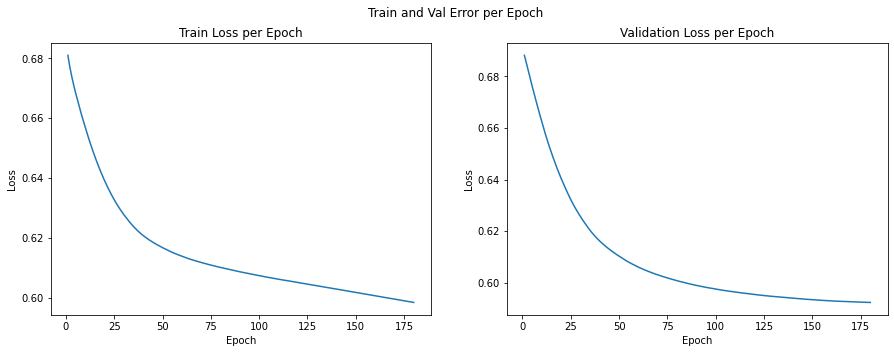

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle("Train and Val Error per Epoch")
ax1.plot(list(range(1,epochs+1)), train_loss_per_epoch)
ax1.set(xlabel='Epoch', ylabel='Loss', title="Train Loss per Epoch")
ax2.plot(list(range(1,epochs+1)), val_loss_per_epoch)
ax2.set(xlabel='Epoch', ylabel='Loss', title="Validation Loss per Epoch")

Very nice looking curves! Unfortunately, not so nice with respect to false positive parity.

0.0
0.05
0.1
0.15
0.75
0.8
0.85
0.9
0.95
1.0
[(0.0, 0.0), (0.05, 0.0), (0.1, 0.002873563218390829), (0.15, 0.04777951933124347), (0.2, 0.10624346917450367), (0.25, 0.21047544409613383), (0.3, 0.2478056426332288), (0.35, 0.22450365726227794), (0.4, 0.19605538140020898), (0.45, 0.12277951933124345), (0.5, 0.12055903866248693), (0.55, 0.11880877742946708), (0.6, 0.12087251828631138), (0.65, 0.10856844305120167), (0.7, 0.07460815047021943), (0.75, 0.03610240334378265), (0.8, 0.023798328108672936), (0.85, 0.013636363636363636), (0.9, 0.006818181818181818), (0.95, 0.0), (1.0, 0.0)]


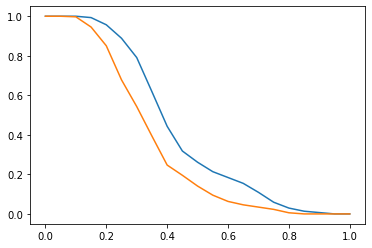

In [39]:
def fpvcalc(threshold, predictor):
    black_highrisk = 0
    black_highrisk_recidivate = 0

    white_highrisk = 0
    white_highrisk_recidivate = 0

    black_lowrisk = 0
    black_lowrisk_recidivate = 0

    white_lowrisk = 0
    white_lowrisk_recidivate = 0

    black_notrecidivate = 0
    black_highrisk_notrecidivate = 0

    white_notrecidivate = 0
    white_highrisk_notrecidivate = 0

    for _, row in test_df.iterrows():   
        x = [row[x] for x in features]
        x = torch.tensor(x).type(torch.FloatTensor)
        pred = 1 if predictor(x).item() >= threshold else 0
        if row['race'] == 'African-American' and pred == 1:
            black_highrisk += 1
            if row['two_year_recid'] == 1:
                black_highrisk_recidivate += 1
            else:
                black_notrecidivate += 1
                black_highrisk_notrecidivate += 1
        elif row['race'] != 'African-American' and pred == 1:
            white_highrisk += 1
            if row['two_year_recid'] == 1:
                white_highrisk_recidivate += 1
            else:
                white_notrecidivate += 1
                white_highrisk_notrecidivate += 1
        elif row['race'] == 'African-American' and pred == 0:
            black_lowrisk += 1
            if row['two_year_recid'] == 1:
                black_lowrisk_recidivate += 1
            else:
                black_notrecidivate += 1
        else:
            white_lowrisk += 1
            if row['two_year_recid'] == 1:
                white_lowrisk_recidivate += 1
            else:
                white_notrecidivate += 1
    return black_highrisk_notrecidivate/black_notrecidivate, white_highrisk_notrecidivate/white_notrecidivate
            
thresholds = [x / 20.0 for x in range(21)]
fp_black = []
fp_white = []
for threshold in thresholds:
    a,b = fpvcalc(threshold, predictorf)
    fp_black.append(a)
    fp_white.append(b)
    if a-b < 0.05:
        print(threshold)
print([(i/20, fp_black[i]-fp_white[i]) for i in range(len(fp_white))])

fig
plt.plot(thresholds, fp_black)
plt.plot(thresholds, fp_white)

# print("\nFalse Postive Parity")
# print(f"P(highrisk | black, did not recidivate) = {black_highrisk_notrecidivate/black_notrecidivate}")
# print(f"P(highrisk | white, did not recidivate) = {white_highrisk_notrecidivate/white_notrecidivate}")

# Difference in base rate = difference between proportion that recidivate in the two groups

Here, false positive parity is not met at threshold of 0.5, or anywhere in the interval [0.2, 0.7]. So, we consider this attempt a fail. We continue playing with hyperparameters until we obtain false positive parity at threshold of 0.5. This is shown in the second attempt below.

### Attempt 2
The only difference here is using a larger learning rate, and training for smaller number of epochs. However, this model actually achieves false positive parity at threshold = 0.5, unlike attempt 1.

#### Import Libraries

- pandas for feature extraction
- numpy for matrix/vector operations
- train_test_split for splitting dataset to train, validation and test sets
- pytorch for ML algorithm, including Dataloader module to go through train set in batches
- matplotlib for plotting train and test loss per epoch

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#### Read Dataset

In this step, read dataset. Then, filter out any row where race is not either African American or Caucasian. Finally, extract only the features we are interested in. 
- Input features of network: 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc' 
- Output of network: two_year_recid prediction
- Input of adversary: network logits (before applying sigmoid function)
- Output of adversary: race prediction

In general, I continued adding variables/features until I observed false parity rate reach within 5%. This was done starting with just two variables, sex and age, and then adding in the order shown below. At the end, it was necessary to convert chargee descriptions to one-hot encodings in order to get the false positive rate within the desired range. The hyperparameters were kept as was in the paper because it would provide an interesting analysis to try and find out what varaibles they used / what was most important, and a way to verify that the features that were claimed to be most important in the paper really were the most indicative of recidivism.

Our results support the claim of the paper. Our features are from their top 10 features list, and they provide a good accuracy (at least, doesnt harm it) while improving false postive at the cost of calibration

In [4]:
# read dataset from .csv file, extract data related strictly to white/black personnel
recidivism_df = pd.read_csv('compas-scores-two-years.csv')
recidivism_df = recidivism_df[(recidivism_df["race"] == "Caucasian") | (recidivism_df["race"] == "African-American")]

recidivism_df = recidivism_df[['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'race', 'two_year_recid']]

#### Convert binary categorical features to one-hot integer representation

There is no need to convert binary categorical variables to their one-hot vector representation. We can simply convert the two categories to 0/1 integer, so it can be used when training the network. Here, we convert male/female under the sex column to 1/0 and Misdemeanor/Felony under the c_charge_degree column to 1/0.

In [5]:
recidivism_df['sex'].replace(['Female','Male'], [0,1], inplace=True) # Encode sex variable
recidivism_df['c_charge_degree'].replace(['F','M'], [0,1], inplace=True) # Encode charge degree variable

Output head as quick visual verification that our encoding above was successful. Both sex and c_charge_degree columns must now have 2 possible values- 0 or 1.

In [6]:
recidivism_df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,race,two_year_recid
1,1,34,0,0,0,0,0,Felony Battery w/Prior Convict,African-American,1
2,1,24,0,0,1,4,0,Possession of Cocaine,African-American,1
3,1,23,0,1,0,1,0,Possession of Cannabis,African-American,0
6,1,41,0,0,0,14,0,Possession Burglary Tools,Caucasian,1
8,0,39,0,0,0,0,1,Battery,Caucasian,0


#### Convert c_charge_desc to a form that could be passed as part of network input

We use one hot vectors. There is a total of 410 unique charge descriptions. These will be converted to one-hot vectors because there is no known correlation between charges with closer integer mappings. Then they will be concatenated with the rest of the inputs.

In [7]:
one_hot = pd.get_dummies(recidivism_df['c_charge_desc']) # convert to one hot encodings
recidivism_df = recidivism_df.drop('c_charge_desc',axis = 1) # get rid of chrage description column, and ...
recidivism_df = recidivism_df.join(one_hot) # replace it with one hot encodings

In [8]:
len(one_hot.columns) # Verify we have done so correctly. This should give 410.

410

#### Construct train, validation and test datasets. Then break each one to input and output tensors.

We use scikit-learn's train_test_split function to construct train, validation and test datasets. We use a 50%-25%-25% split ratio for train, validation, test data, respectively. 

In [9]:
# Create train, validation and test datasets
train_df, test_val_df = train_test_split(recidivism_df, test_size=0.4) # 60% for train
val_df, test_df = train_test_split(test_val_df, test_size=0.5) # 50% of 40% = 20% for each of val, test

# train features
features = list(recidivism_df.columns)
features.remove('race')
features.remove('two_year_recid')

# number of inputs
num_features = len(features)

# construct input and output for each of the 3 datasets
predictor_X_train = torch.tensor(train_df[features].to_numpy()).type(torch.FloatTensor)
predictor_y_train = torch.tensor(train_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

predictor_X_val = torch.tensor(val_df[features].to_numpy()).type(torch.FloatTensor)
predictor_y_val = torch.tensor(val_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

predictor_X_test = torch.tensor(test_df[features].to_numpy()).type(torch.FloatTensor)
predictor_y_test = torch.tensor(test_df['two_year_recid'].to_numpy()).type(torch.FloatTensor)

# Input for adversary will come from output of predictor, so only define outputs
adversary_y_train = torch.tensor([1 if race == 'African-American' else 0 for race in list(train_df['race'])]).type(torch.FloatTensor)
adversary_y_val = torch.tensor([1 if race == 'African-American' else 0 for race in list(val_df['race'])]).type(torch.FloatTensor)
adversary_y_test = torch.tensor([1 if race == 'African-American' else 0 for race in list(test_df['race'])]).type(torch.FloatTensor)

#### Construct train, validation and test data arrays. Each array's elements are lists, containing ith train data, ith prediction and ith entry's race.

The arrays constructed here will be useful for constructing DataLoader objects

In [10]:
predictor_train_data, predictor_val_data, predictor_test_data = [], [], []

# Construct train data
for i in range(len(predictor_X_train)):
    predictor_train_data.append([predictor_X_train[i], predictor_y_train[i], adversary_y_train[i]])
    
# Construct validation data
for i in range(len(predictor_X_val)):
    predictor_val_data.append([predictor_X_val[i], predictor_y_val[i], adversary_y_val[i]])
    
# Construct test data
for i in range(len(predictor_X_test)):
    predictor_test_data.append([predictor_X_test[i], predictor_y_test[i], adversary_y_test[i]])

#### Create DataLoader objects for each dataset. Set batch size to 64.

This will be useful in training with minibatch size of 64

In [11]:
# set batch size to 64, standard size for ML procedures
batch_size = 64

# Create train, val and test dataloaders. Will be used later in training
train_dataloader = DataLoader(predictor_train_data, batch_size=batch_size)
val_dataloader = DataLoader(predictor_val_data, batch_size=batch_size)
test_dataloader = DataLoader(predictor_test_data, batch_size=batch_size)

#### Define architecture for network and adversary

If we had gpu, would set device = "gpu" for faster training.

We use the same network architectures as defined in the paper "Achieving Fairness through Adversarial Learning: an Application to Recidivism Prediction" 

Specifically:\
"Predictor N has 2 256-unit ReLU hidden layers.\
Adversary A has a single 100-unit ReLU hidden layer. We\
used a learning rate of e−4, binary cross entropy loss, a\
sigmoid output layer, an Adam optimizer, and an alpha value of 1." 

In [18]:
device = "cpu" # Too poor for GPU

# Predictor architecture
class RecidivismPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RecidivismPredictor, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits_post_sigmoid = torch.sigmoid(logits)
        return logits_post_sigmoid

# Adversary architecture
class Adversary(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Adversary, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim),
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits_post_sigmoid = torch.sigmoid(logits)
        return logits_post_sigmoid

# Create predictor and adversary models (initialized with random weights)
predictor = RecidivismPredictor(num_features,1).to(device)
adversary = Adversary(1,1).to(device)

#### Define train, inference and adversary test functions

In training, we want to iteratively train our network such that we improve adversary, then network, and repeat in this manner until model loss on the validation set stops decreasing. This way, we achieve a model with high accuracy on validation set, without overfitting to the train set. 

The inference function gives us the accuracy and loss of our predictor model on any dataloader. It can be used to determine model accuracy on train set, validation set, or test set.

The test_adversary function allows us to test adversary. As required, this is done by passing input through the predictor to obtain the logits, then passing logits to adversary to obtain race prediction. The goal is that adversary performs poorly.

In [19]:
# Train function
def train(dataloader, predictor, adversary, loss_fn, predictor_optimizer, adversary_optimizer, alpha):
    size = len(dataloader.dataset)
    predictor.train()
    adversary.train()
    
    # 1. Adversary
    print("IMPROVING ADVERSARY")
    for batch, (X, y, race) in enumerate(dataloader): # loop through batches
        X, y, race = X.to(device), y.to(device), race.to(device)
        
        # Forward prop
        pred = predictor.linear_relu_stack(X) # obtain logit 
        race_pred = adversary(pred) # from logit get race prediction through adversary
        adversary_loss = loss_fn(torch.squeeze(race_pred).type(torch.FloatTensor), race.type(torch.FloatTensor)) # compute loss
        
        # Backprop: Update adversarial net parameters
        adversary_optimizer.zero_grad()
        adversary_loss.backward()
        adversary_optimizer.step()        
        
        # Print loss after every 10 batches
        if batch % 10 == 0:
            loss, current = adversary_loss.item(), batch * 64
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    test_adversary(val_dataloader, predictor, adversary, loss_fn) # should get better
    
    # 2. Network 
    print("IMPROVING NETWORK")
    for batch, (X, y, race) in enumerate(dataloader): # loop through batches
        X, y, race = X.to(device), y.to(device), race.to(device)
        
        # Forward prop
        logit = predictor.linear_relu_stack(X) # obtain logit
        pred = predictor(X) # recidivism prediction
        race_pred = adversary(logit) # from logit get race prediction through adversary
        
        # Need both losses
        adversary_loss = loss_fn(torch.squeeze(race_pred).type(torch.FloatTensor), race.type(torch.FloatTensor))        
        predictor_loss = loss_fn(torch.squeeze(pred).type(torch.FloatTensor), y.type(torch.FloatTensor))
        # Use formula given in paper, with same hyperparameters
        network_loss = predictor_loss - alpha*adversary_loss
        
        # Backprop to update networks parameters
        predictor_optimizer.zero_grad()
        network_loss.backward()
        predictor_optimizer.step()
        
        # Print predictor loss every 10 batches
        if batch % 10 == 0:
            loss, current = predictor_loss.item(), batch * 64
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    test_adversary(val_dataloader, predictor, adversary, loss_fn) # should have gotten worse
    
    # Validation Set
    c, tl, n = inference(val_dataloader, predictor, loss_fn)
    # keep track of validation loss to monitor overfit
    print(f"Validation Error: \n Accuracy: {(100*c):>0.1f}%, Avg loss: {tl:>8f} \n Num Batches: {n}") 

# Predictor inference method
def inference(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        # loop through batches
        for X, y, race in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Obtain prediction, then calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(torch.squeeze(pred).type(torch.FloatTensor), y.type(torch.FloatTensor)).item()
            correct += np.sum(torch.squeeze(pred).round().numpy() == y.numpy())  
            
    # Determine overall loss and accuracy
    test_loss /= num_batches
    correct /= size
    
    return correct, test_loss, num_batches

# How good can we predict race? Hopefully not too well...
def test_adversary(dataloader, predictor, adversary, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Need both networks to predict race
    predictor.eval()
    adversary.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        # loop through batches
        for X, y, race in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Obtain logit form predictor, then run through adversary
            logit = predictor.linear_relu_stack(X)
            race_pred = adversary(logit)
            
            # The usual thing...
            test_loss += loss_fn(torch.squeeze(race_pred).type(torch.FloatTensor), race.type(torch.FloatTensor))
            correct += np.sum(torch.squeeze(race_pred).round().numpy() == race.numpy())  
    
    # Compute overall loss and accuracy
    test_loss /= num_batches
    correct /= size
    print(f"Adversary Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")

#### Train Adversarial Network

Iteratively train adversary and predictor network. Use the following hyperparameter settings, mostly determined by the paper "Achieving Fairness through Adversarial Learning: an Application to Recidivism Prediction".
- loss_fn = binary cross entropy loss (from paper)
- learning rate = 1e-3 (tuned to particular dataset, e-3 was found to give better results than e-4)
- adam optimizer (from paper)
- 20 epochs (trained for more than 20 epochs and saw increase in validation set error after 25 epochs. So, changed to 25 epochs in next iteration)
- alpha = 1

In [20]:
# Specify hyperparamter
loss_fn = nn.BCELoss() # binary cross entropy loss
lrate = 1e-3 # 0.001 learning rate
predictor_optimizer = torch.optim.Adam(predictor.parameters(), lr=lrate) # adam optmizer
adversary_optimizer = torch.optim.Adam(adversary.parameters(), lr=lrate) # adam optimizer
alpha = 1 # same as paper

# Execute training for 20 epochs
epochs = 20
train_loss_per_epoch = []
val_loss_per_epoch = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, predictor, adversary, loss_fn, predictor_optimizer, adversary_optimizer, alpha)
    # keep track of train and val loss per epoch
    train_loss_per_epoch.append(inference(train_dataloader, predictor, loss_fn)[1])
    val_loss_per_epoch.append(inference(val_dataloader, predictor, loss_fn)[1])
print("Done!")

Epoch 1
-------------------------------
IMPROVING ADVERSARY
loss: 0.698834  [    0/ 3690]
loss: 0.658693  [  640/ 3690]
loss: 0.686142  [ 1280/ 3690]
loss: 0.637115  [ 1920/ 3690]
loss: 0.714719  [ 2560/ 3690]
loss: 0.690223  [ 3200/ 3690]
Adversary Test Error: 
 Accuracy: 60.08130%, Avg loss: 0.672179 

IMPROVING NETWORK
loss: 0.671511  [    0/ 3690]
loss: 0.681898  [  640/ 3690]
loss: 0.695412  [ 1280/ 3690]
loss: 0.633168  [ 1920/ 3690]
loss: 0.609777  [ 2560/ 3690]
loss: 0.590117  [ 3200/ 3690]
Adversary Test Error: 
 Accuracy: 65.12195%, Avg loss: 0.643609 

Validation Error: 
 Accuracy: 63.3%, Avg loss: 0.632027 
 Num Batches: 20
Epoch 2
-------------------------------
IMPROVING ADVERSARY
loss: 0.607986  [    0/ 3690]
loss: 0.604622  [  640/ 3690]
loss: 0.696407  [ 1280/ 3690]
loss: 0.640363  [ 1920/ 3690]
loss: 0.665490  [ 2560/ 3690]
loss: 0.693406  [ 3200/ 3690]
Adversary Test Error: 
 Accuracy: 66.09756%, Avg loss: 0.625896 

IMPROVING NETWORK
loss: 0.702622  [    0/ 3690]
lo


Validation Error: 
 Accuracy: 66.5%, Avg loss: 0.632252 
 Num Batches: 20
Epoch 14
-------------------------------
IMPROVING ADVERSARY
loss: 0.628696  [    0/ 3690]
loss: 0.620154  [  640/ 3690]
loss: 0.715217  [ 1280/ 3690]
loss: 0.663260  [ 1920/ 3690]
loss: 0.690246  [ 2560/ 3690]
loss: 0.701568  [ 3200/ 3690]
Adversary Test Error: 
 Accuracy: 61.13821%, Avg loss: 0.656160 

IMPROVING NETWORK
loss: 0.674603  [    0/ 3690]
loss: 0.458734  [  640/ 3690]
loss: 0.697748  [ 1280/ 3690]
loss: 0.579190  [ 1920/ 3690]
loss: 0.559510  [ 2560/ 3690]
loss: 0.590551  [ 3200/ 3690]
Adversary Test Error: 
 Accuracy: 61.54472%, Avg loss: 0.656264 

Validation Error: 
 Accuracy: 66.4%, Avg loss: 0.636716 
 Num Batches: 20
Epoch 15
-------------------------------
IMPROVING ADVERSARY
loss: 0.633495  [    0/ 3690]
loss: 0.620445  [  640/ 3690]
loss: 0.713616  [ 1280/ 3690]
loss: 0.661283  [ 1920/ 3690]
loss: 0.691483  [ 2560/ 3690]
loss: 0.700560  [ 3200/ 3690]
Adversary Test Error: 
 Accuracy: 61.46

#### Plot results of training

Plot training and validation losses after each epoch. Training loss decreases steadily with epochs. Validation loss decreases, but then begins to increase. On other trails (many many were done...), the validation loss usually didn't start increasing so early, so we do not want to reduce number of epochs. The final model, as we shall see, achieves good results, so we keep this run.

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Validation Loss per Epoch')]

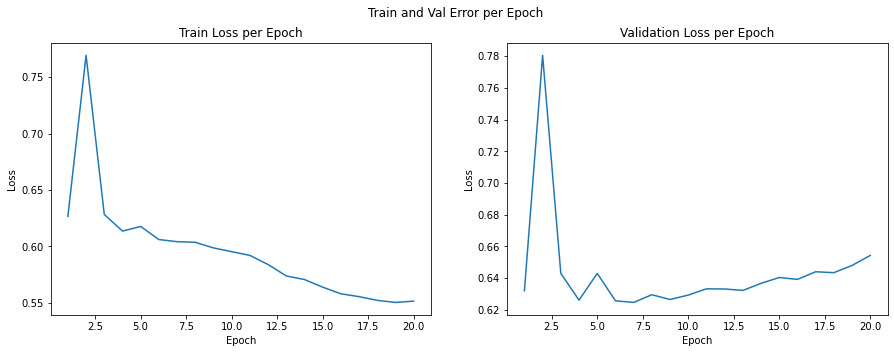

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle("Train and Val Error per Epoch")
ax1.plot(list(range(1,epochs+1)), train_loss_per_epoch)
ax1.set(xlabel='Epoch', ylabel='Loss', title="Train Loss per Epoch")
ax2.plot(list(range(1,epochs+1)), val_loss_per_epoch)
ax2.set(xlabel='Epoch', ylabel='Loss', title="Validation Loss per Epoch")

#### Define function that return false positive rates for black and white demographics, given a threshold, appropriately passed in as argument "threshold" to the fpvcalc function

In [22]:
'''
Same as part 1 of this project
'''
def fpvcalc(threshold):
    black_highrisk = 0
    black_highrisk_recidivate = 0

    white_highrisk = 0
    white_highrisk_recidivate = 0

    black_lowrisk = 0
    black_lowrisk_recidivate = 0

    white_lowrisk = 0
    white_lowrisk_recidivate = 0

    black_notrecidivate = 0
    black_highrisk_notrecidivate = 0

    white_notrecidivate = 0
    white_highrisk_notrecidivate = 0

    for _, row in test_df.iterrows():   
        x = [row[x] for x in features]
        x = torch.tensor(x).type(torch.FloatTensor)
        pred = 1 if predictor(x).item() >= threshold else 0
        if row['race'] == 'African-American' and pred == 1:
            black_highrisk += 1
            if row['two_year_recid'] == 1:
                black_highrisk_recidivate += 1
            else:
                black_notrecidivate += 1
                black_highrisk_notrecidivate += 1
                
        elif row['race'] != 'African-American' and pred == 1:
            white_highrisk += 1
            if row['two_year_recid'] == 1:
                white_highrisk_recidivate += 1
            else:
                white_notrecidivate += 1
                white_highrisk_notrecidivate += 1
                
        elif row['race'] == 'African-American' and pred == 0:
            black_lowrisk += 1
            if row['two_year_recid'] == 1:
                black_lowrisk_recidivate += 1
            else:
                black_notrecidivate += 1
                
        else:
            white_lowrisk += 1
            if row['two_year_recid'] == 1:
                white_lowrisk_recidivate += 1
            else:
                white_notrecidivate += 1
    return black_highrisk_notrecidivate/black_notrecidivate, white_highrisk_notrecidivate/white_notrecidivate

#### For each threshold from 0 to 1, with increments of 0.05, determine and store false positive rates for each demographic. Plot results in one figure to determine if false positive parity is achieved.

0.0
0.05
0.1
0.4
0.5
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
[(0.0, 0.0), (0.05, 0.011184913727286583), (0.1, 0.013837990532905797), (0.15, 0.06373110398534132), (0.2, 0.08255077111009312), (0.25, 0.07317911131470456), (0.3, 0.11515116811726983), (0.35, 0.07199572453809738), (0.4, 0.049721331500992505), (0.45, 0.050484806840739055), (0.5, 0.04344174683157734), (0.55, 0.054015880287066734), (0.6, 0.05899755687891281), (0.65, 0.03578790655061841), (0.7, 0.043040922278210415), (0.75, 0.02210261108566193), (0.8, 0.005706978164605282), (0.85, 0.0011642998931134518), (0.9, 0.002271339135745915), (0.95, 0.0), (1.0, 0.0)]


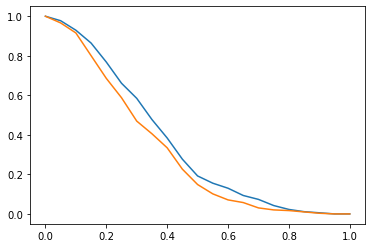

In [24]:
thresholds = [x / 20.0 for x in range(21)]
fp_black = []
fp_white = []
for threshold in thresholds:
    a,b = fpvcalc(threshold)
    fp_black.append(a)
    fp_white.append(b)
    if a-b < 0.05:
        print(threshold)
print([(i/20, fp_black[i]-fp_white[i]) for i in range(len(fp_white))])

fig
plt.plot(thresholds, fp_black)
plt.plot(thresholds, fp_white)

As we can see, false postive parity is achieved at nearly every threshold, including threashold = 0.5

#### Show accuracy is held

Run inference on test set

In [26]:
c, tl, n = inference(test_dataloader, predictor, loss_fn)
print(f"Test Error: \n Accuracy: {(100*c):>0.1f}%, Avg loss: {tl:>8f}")

Test Error: 
 Accuracy: 67.1%, Avg loss: 0.627049


As we can see, accuracy has improved. We have gone from accuracy of 65.3% in part 1 to 67.1%. 

Thus, FPR parity is satisfied without harming accuracy. Infact, our experiments confirm that using Wadsworth et al.’s network with more features than part 1 produces a more accurate classifier.